# MNIST classifier in IBM FL

## Outline:
- [Add conda environment to Jupyter Notebook](#setup)
- [Federated Learning(FL)](#intro)
- [Digit Recognition](#mnist)
- [Aggregator](#Aggregator)
    - [Aggregator Configuration](#Aggregator-Configuration)
    - [Running the Aggregator](#Running-the-Aggregator)
- [Starting Parties](#Starting-Parties)
- [Training and Evaluation](#Training-and-Evaluation)
- [Visualize Results](#Visualize-Results)
- [Shut Down](#Shut-Down)

## Add conda environment to Jupyter Notebook <a name="setup"></a>

Please ensure that you have activated the `conda` environment following the instructions in the project README.

Once done, run the following commands in your terminal to install your conda environment into the Jupyter Notebook:

1. Once you have activated the conda environment, install the `ipykernel` package: `conda install -c anaconda ipykernel`

2. Next, install the `ipykernel` module within Jupyter Notebook: `python -m ipykernel install --user --name=<conda_env>`

3. Please install the `matplotlib` package for your conda environment.

4. Finally, restart the jupyter notebook once done. Ensure that you are running this Notebook from `<project_path>/examples/keras_classifier`, where project_path is the directory where the IBMFL repository was cloned.

When the Notebook is up and running it may prompt you to choose the kernel. Use the drop down to choose the kernel name same as that chosen when running `conda activate <conda_env>`. If no prompt shows up, you can change the kernel by clicking _Kernel_ > _Change kernel_ > _`<conda_env>`_.

## Federated Learning (FL) <a name="intro"></a>

**Federated Learning (FL)** is a distributed machine learning process in which each participant node (or party) retains their data locally and interacts with  other participants via a learning protocol. 
One main driver behind FL is the need to not share data with others  due to privacy and confidentially concerns.
Another driver is to improve the speed of training a machine learning model by leveraging other participants' training processes.

Setting up such a federated learning system requires setting up a communication infrastructure, converting machine learning algorithms to federated settings and in some cases knowing about the intricacies of security and privacy enabling techniques such as differential privacy and multi-party computation. 

In this Notebook we use [IBM FL](https://github.com/IBM/federated-learning-lib) to have multiple parties train a classifier to recognise handwritten digits in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). 

For a more technical dive into IBM FL, refer the whitepaper [here](https://arxiv.org/pdf/2007.10987.pdf).

In the following cells, we set up each of the components of a Federated Learning network (See Figure below) wherein all involved parties aid in training their respective local cartpoles to arrive at the upright pendulum state. In this notebook we default to 2 parties, but depending on your resources you may use more parties.

<img src="../images/FL_Network.png" width="720"/>
<figcaption><center>Modified from Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></center></figcaption>

## Digit Recognition <a name="mnist"></a>



<img src="../images/MnistExamples.png" width="512"/>
<figcaption><center>Image Source: Josef Steppan / CC BY-SA <a href="https://creativecommons.org/licenses/by-sa/4.0">Wikimedia Commons</a></center></figcaption>

The problem at hand is to recognize digits from these tens of thousands of handwritten images. In this notebook, we are going to assume that the parties and the aggregator are run in the same machine. For that purpose, we first randomly split the training data to each party. Then, we define the neural network definition. After that we start the aggregator and we need to register and run all parties by running two other notebooks.

### Getting things ready
We begin by setting the number of parties that will participate in the federated learning run and splitting up the data among them.

In [1]:
use_dp = False
budget = 1.0
delta = 0.005
fig_name = 'no_dp.PDF'

In [2]:
import sys
sys.path.append('../..')
import os
os.chdir("../..")

num_parties = 2  ## number of participating parties
dataset = 'mnist'

In [2]:
!ifconfig # NOTE: Edge_addr should be the host, 155 addr, or end of ip tunnel 192

enp10s3f0: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 1500
        inet6 fe80::204:23ff:feb7:18f4  prefixlen 64  scopeid 0x20<link>
        ether 00:04:23:b7:18:f4  txqueuelen 1000  (Ethernet)
        RX packets 294  bytes 36662 (36.6 KB)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 313  bytes 38578 (38.5 KB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0

enp6s7: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 1500
        inet 155.98.39.117  netmask 255.255.252.0  broadcast 155.98.39.255
        inet6 fe80::211:43ff:fee4:5c03  prefixlen 64  scopeid 0x20<link>
        ether 00:11:43:e4:5c:03  txqueuelen 1000  (Ethernet)
        RX packets 1985866  bytes 2836261722 (2.8 GB)
        RX errors 0  dropped 14  overruns 0  frame 0
        TX packets 677297  bytes 89822441 (89.8 MB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0

lo: flags=73<UP,LOOPBACK,RUNNING>  mtu 65536
        inet 127.0.0.1  netmask 255.0.0.0
      

In [3]:
edge_addr = '192.168.0.1'

We use `examples/generate_data.py` to split the dataset into files for each party. 

The script allows specifying the number of parties as well as the dataset to use (from several supported datasets: _mnist_, _femnist_, _cifar10_ and many others). 

The `-pp` argument states how many data points to choose per party. If the option `--stratify` is given, the library stratifies the data proportionally according to the source distribution. If you want to run this notebook in different machines, you can assign samples for each party locally. Then, we define the neural network definition.

In [4]:
%run examples/generate_data.py -n $num_parties -d $dataset -pp 200 

Using TensorFlow backend.
/mydata/conda/envs/tf2/lib/python3.6/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 's3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Party_ 0
nb_x_train:  (200, 28, 28) nb_x_test:  (10000, 28, 28)
* Label  0  samples:  13
* Label  1  samples:  22
* Label  2  samples:  18
* Label  3  samples:  27
* Label  4  samples:  19
* Label  5  samples:  13
* Label  6  samples:  25
* Label  7  samples:  29
* Label  8  samples:  16
* Label  9  samples:  18
Finished! :) Data saved in  examples/data/mnist/random


Generate the keras model definition file using the below function save_model_config. Please note that parties data and the model file needs to be copied to the parties if you launch parties on different nodes.

In [5]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K

def save_model_config(folder_configs):
    num_classes = 10
    img_rows, img_cols = 28, 28
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_rows, img_cols)
    else:
        input_shape = (img_rows, img_cols, 1)

    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="adam", metrics=["accuracy"])

    if not os.path.exists(folder_configs):
        os.makedirs(folder_configs)

    # Save model
    fname = os.path.join(folder_configs, 'compiled_keras.h5')
    model.save(fname)
    print(fname)

    K.clear_session()
    # Generate model spec:
    spec = {
        'model_name': 'keras-cnn',
        'model_definition': fname
    }

    model = {
        'name': 'KerasFLModel',
        'path': 'ibmfl.model.keras_fl_model',
        'spec': spec
    }

    return model
save_model_config('examples/configs/keras_classifier')

examples/configs/keras_classifier/compiled_keras.h5


{'name': 'KerasFLModel',
 'path': 'ibmfl.model.keras_fl_model',
 'spec': {'model_name': 'keras-cnn',
  'model_definition': 'examples/configs/keras_classifier/compiled_keras.h5'}}

## Aggregator

coordinates the overall process, communicates with the parties and integrates the results of the training process. This integration of results is done using the _Fusion Algorithm_.

A fusion algorithm queries the registered parties to carry out the federated learning process. The queries sent vary according to the model/algorithm type.  In return, parties send their reply as a model update object, and these model updates are then aggregated according to the specified Fusion Algorithm, specified via a `Fusion Handler` class. 

To take a look at the supported fusion algorithms, refer the IBM FL tutorial page [here](https://github.com/IBM/federated-learning-lib/blob/main/README.md#supported-functionality).

### Aggregator Configuration

We discuss the various configuration parameters for the Aggregator [here.](https://github.com/IBM/federated-learning-lib/blob/main/docs/tutorials/configure_fl.md#the-aggregators-configuration-file)

Given below is an example of the aggregator's configuration file. In this example, the aggregator does not specify a data file or maintain a global model. Hence, during the federated learning process, it only keeps track of the current model parameters. 

However, it is possible that the aggregator also has data for testing purposes and maintains a global model. When this is the case, one needs to add `data` and `model` sections in the configuration file.

<img src="../images/arch_aggregator.png" width="680"/>
<figcaption><center>Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></center></figcaption>

#### Building blocks in the configuration file:

- `connection` (also used in Party config): needed to initiate the connection; includes server information (`info`, optional, depends on the connection type), a connection class name, a connection file location, and a synchronization mode flag (`sync`) for training phase

- `fusion`: needed to initiate a fusion algorithm at the aggregator side; includes a fusion handler class name and a fusion handler file location

- `protocol_handler`: needed to initiate a protocol; includes a protocol handler class name and a protocol handler file location

- `hyperparams`: includes global training and local training hyperparameters, including `termination_accuracy`, learning rate (`lr`), `optimizer`, etc., depending on the model being used.

For detailed documentation of the objects described below, refer the API docs [here](https://ibmfl.mybluemix.net/api-documentation).

In [6]:
agg_config = {
    'connection': {
        'info': {
            'ip': edge_addr,
            'port': 5000,
            'tls_config': {
                'enable': 'false'
            }
        },
        'name': 'FlaskConnection',
        'path': 'ibmfl.connection.flask_connection',
        'sync': 'False'
    },
    'data': {
        'info': {
            'npz_file': 'examples/datasets/mnist.npz'
        },
        'name': 'MnistKerasDataHandler',
        'path': 'ibmfl.util.data_handlers.mnist_keras_data_handler'
    },
    'fusion': {
        'name': 'IterAvgFusionHandler',
        'path': 'ibmfl.aggregator.fusion.iter_avg_fusion_handler'
    },
    'hyperparams': {
        'global': {
            'max_timeout': 60,
            'num_parties': num_parties,
            'perc_quorum': 1,
            'rounds': 30,
            'termination_accuracy': 0.9
        },
        'local': {
            'optimizer': {
                'lr': 0.01
            },
            'training': {
                'epochs': 3
            }
        }
    },
    'protocol_handler': {
        'name': 'ProtoHandler',
        'path': 'ibmfl.aggregator.protohandler.proto_handler'
    }
}

In [7]:
if use_dp:
    agg_config = {
        'connection': {
            'info': {
                'ip': edge_addr,
                'port': 5000,
                'tls_config': {
                    'enable': 'false'
                }
            },
            'name': 'FlaskConnection',
            'path': 'ibmfl.connection.flask_connection',
            'sync': 'False'
        },
        'data': {
            'info': {
                'npz_file': 'examples/datasets/mnist.npz'
            },
            'name': 'MnistKerasDataHandler',
            'path': 'ibmfl.util.data_handlers.mnist_keras_data_handler'
        },
        'fusion': {
            'name': 'IterAvgFusionHandler',
            'path': 'ibmfl.aggregator.fusion.iter_avg_fusion_handler'
        },
        'hyperparams': {
            'global': {
                'max_timeout': 600,
                'num_parties': num_parties,
                'perc_quorum': 1,
                'rounds': 30,
                'termination_accuracy': 0.9
            },
            'local': {
                'optimizer': {
                    'lr': 0.01
                },
                'training': {
                    'epochs': 3
                },
                'privacy': {
                    'budget': budget,
                    'delta': delta
                }
            }
        },
        'protocol_handler': {
            'name': 'ProtoHandler',
            'path': 'ibmfl.aggregator.protohandler.proto_handler'
        }
    }

### Running the Aggregator
Next we pass the configuration parameters set in the previous cell to instantiate the `Aggregator` object. Finally, we `start()` the Aggregator process.

In [8]:

from ibmfl.aggregator.aggregator import Aggregator
aggregator = Aggregator(config_dict=agg_config)

aggregator.start()

2021-04-16 08:56:11,508 | 1.0.4 | INFO | ibmfl.util.config                             | Getting Aggregator details from arguments.
2021-04-16 08:56:12,151 | 1.0.4 | INFO | ibmfl.util.config                             | No model config provided for this setup.
2021-04-16 08:56:12,318 | 1.0.4 | INFO | ibmfl.util.config                             | No data config provided for this setup.
2021-04-16 08:56:12,319 | 1.0.4 | INFO | ibmfl.util.data_handlers.mnist_keras_data_handler | Loaded training data from examples/datasets/mnist.npz
2021-04-16 08:56:12,732 | 1.0.4 | INFO | ibmfl.connection.flask_connection             | RestSender initialized
2021-04-16 08:56:12,733 | 1.0.4 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.START
2021-04-16 08:56:12,734 | 1.0.4 | INFO | ibmfl.connection.flask_connection             | Receiver Initialized
2021-04-16 08:56:12,735 | 1.0.4 | INFO | ibmfl.connection.flask_connection             | Initializing Flask application
2021-04-16 

<img src="../images/arch_party.png" width="680"/>
<figcaption><center>Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></center></figcaption>

## Starting Parties

Now that we have Aggregator running, next we go to Parties' notebooks (`keras_classifier_p0.ipynb` and `keras_classifier_p1.ipynb`) to start and register them with the Aggregator. Once all the parties are done with registration, we will move to next step to start training.

## Training and Evaluation

Now that our network has been set up, we begin training the model by invoking the Aggregator's `start_training()` method. 

This could take some time, depending on your system specifications. Feel free to get your doze of coffee meanwhile ☕

In [9]:
"""
#1 Initialize the metrics collector variables
"""
num_parties = agg_config['hyperparams']['global']['num_parties']
eval_party_accuracy = [[] for _ in range(num_parties)]
iterations = [[] for _ in range(num_parties)]

"""
#2 Register handler for metrics collector
"""
def get_metrics(metrics):
    keys = list(metrics['party'].keys())
    keys.sort()
    for i in range(len(keys)):
      eval_party_accuracy[i].append(metrics['party'][keys[i]]['accuracy'])
      iterations[i].append(metrics['fusion']['curr_round']*agg_config['hyperparams']['local']['training']['epochs'])
      
mh = aggregator.fusion.metrics_manager
mh.register(get_metrics)


"""
#3 start the training
"""
aggregator.start_training()

2021-04-16 08:58:10,928 | 1.0.4 | INFO | ibmfl.aggregator.aggregator                   | Initiating Global Training.
2021-04-16 08:58:10,930 | 1.0.4 | INFO | ibmfl.aggregator.fusion.fusion_handler        | Warm start disabled.
2021-04-16 08:58:10,931 | 1.0.4 | INFO | ibmfl.aggregator.fusion.iter_avg_fusion_handler | Model updateNone
2021-04-16 08:58:10,932 | 1.0.4 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.SND_MODEL
2021-04-16 08:58:10,935 | 1.0.4 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.SND_REQ
2021-04-16 08:59:12,995 | 1.0.4 | ERROR | ibmfl.aggregator.protohandler.proto_handler   | Error occurred while sending request to party: <ibmfl.aggregator.party_connection.PartyConnection object at 0x7f72c03a7a58> - HTTPConnectionPool(host='192.168.0.2', port=8085): Max retries exceeded with url: /7 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f72c0301710>: Failed to establish a new connection: [Er

False

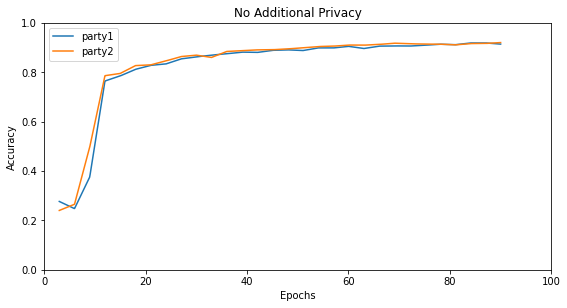

In [12]:
"""
#1 define a method to plot a smooth cure
"""
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

def smooth_curve(xaxis, yaxis):
   xnew = np.linspace(min(xaxis), max(xaxis), len(xaxis)*50) 

   spl = make_interp_spline(xaxis, yaxis, k=1)  # type: BSpline
   power_smooth = spl(xnew)
   return xnew, power_smooth 

f = plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)

num_parties = agg_config['hyperparams']['global']['num_parties']


"""
#2 plot the evaluation curve
"""
for i in range(num_parties):
    eval_party_xaxis, eval_party_yaxis = smooth_curve(iterations[i], eval_party_accuracy[i])
    line1, = plt.plot(eval_party_xaxis, eval_party_yaxis)
    line1.set_label('party'+str(i+1))

if use_dp:
    plt.title(f'({budget}, {delta}) Differentially Private')
else:
    plt.title(f'No Additional Privacy')
    
plt.axis([0, 100, 0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.savefig(f'/users/agot/{fig_name}', bbox_inches='tight')
plt.show()

## Shut Down

Invoke the `stop()` method on each of the network participants to terminate the service.

In [8]:
aggregator.stop()

2020-10-05 15:23:59,072 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.SND_REQ
2020-10-05 15:23:59,202 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Total number of success responses :2
2020-10-05 15:23:59,204 -STD ibmfl.connection.flask_connection - INFO - Stopping Receiver and Sender
2020-10-05 15:23:59,214 -STD werkzeug - INFO - 127.0.0.1 - - [05/Oct/2020 15:23:59] "POST /shutdown HTTP/1.1" 200 -
2020-10-05 15:23:59,219 -STD ibmfl.aggregator.aggregator - INFO - Aggregator stop successful


## Visualize Parties' Training
Please go to Parties' notebooks to visalize summary of Parties' training.